In [57]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.axes as axt
import glob
import anndata
import bbknn
import celltypist 
from celltypist import models

In [58]:
data_path = '../data/'
data_path_1 = '../data/SCP1884/'
data_path_2 = '../data/SCP259/'

In [59]:
adata = sc.read_h5ad(data_path_1 + 'SCP1884.epi.qc.h5ad')
adata2 = sc.read_h5ad(data_path_2 + 'SCP259.epi.qc.h5ad')
adata.obs['dataset'] = "CD_SCP1884"
adata2.obs['dataset'] = "UC_SCP259"
adata_comb = adata.concatenate(adata2,batch_key='dataset')



In [61]:
adata_comb.shape

(220351, 18771)

In [62]:
adata = adata_comb

In [63]:
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
adata = adata[adata.obs['predicted_doublets'].isin([False])]


In [64]:
adata.shape

(164563, 18771)

In [65]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)


In [66]:
adata.raw = adata

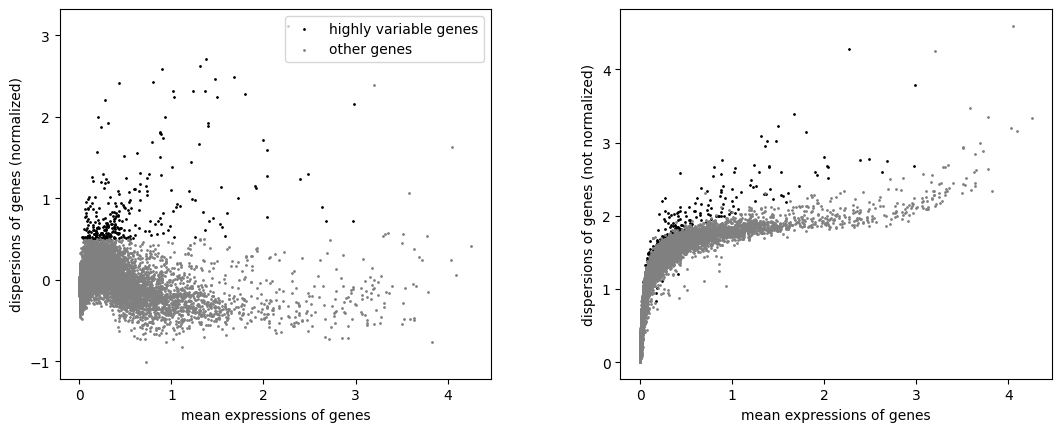

In [67]:
sc.pp.highly_variable_genes(adata, batch_key='Sample')
adata.var.highly_variable.value_counts()
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]

In [68]:
adata.var.highly_variable.value_counts()

highly_variable
True    291
Name: count, dtype: int64

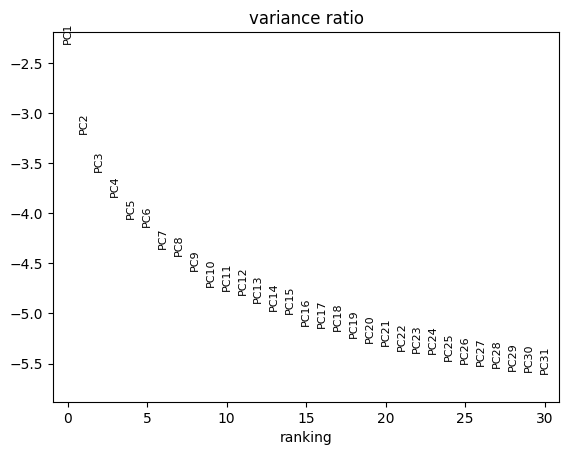

In [69]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


In [70]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=17, knn=True)
sc.tl.umap(adata)


In [71]:
sc.tl.leiden(adata, resolution=0.3)

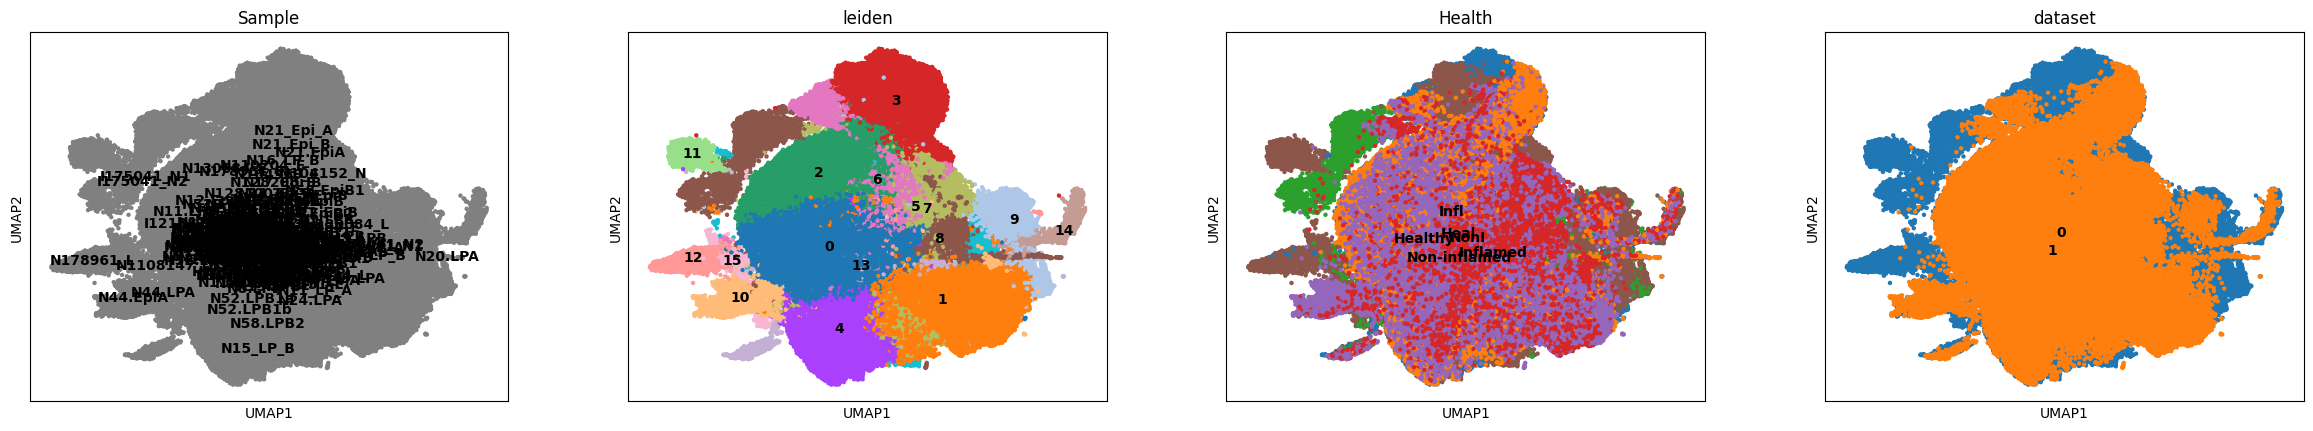

In [72]:
sc.pl.umap(adata, color=['Sample','leiden','Health','dataset'],legend_loc='on data',size=40)

In [73]:
bbknn.ridge_regression(adata,batch_key=['Subject'], confounder_key=['leiden'])
sc.tl.pca(adata)
bbknn.bbknn(adata,batch_key='Subject') 


In [74]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=17, knn=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.3)


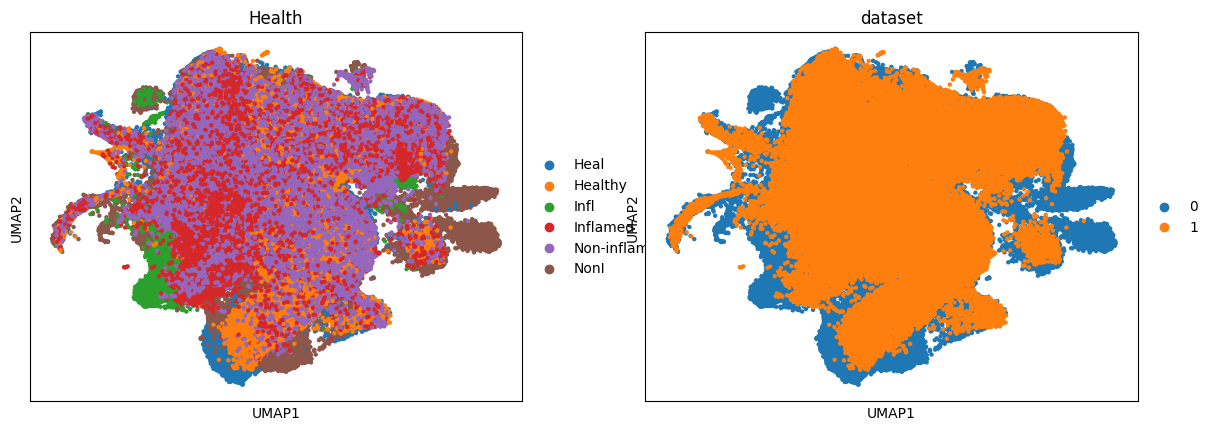

In [75]:
sc.pl.umap(adata, color=['Health','dataset'],size=40)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 164563 cells and 18771 genes
🔗 Matching reference genes in the model
🧬 1584 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


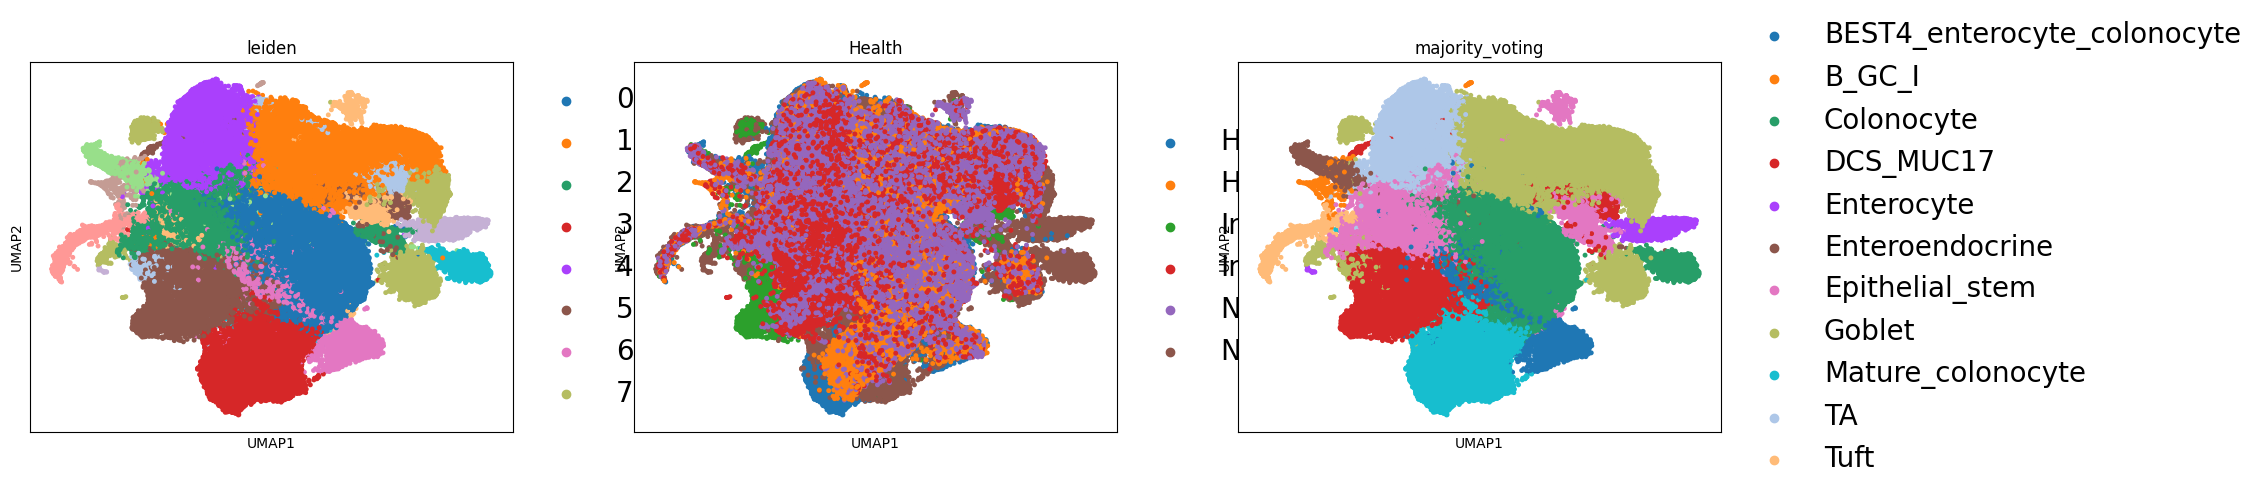

In [76]:
model = models.Model.load(model='full_gi.pkl')
predictions = celltypist.annotate(adata,model,majority_voting=True,over_clustering='leiden')
predictions.predicted_labels
adata_p = predictions.to_adata()
sc.pl.umap(adata,color=['leiden','Health','majority_voting'],size=50,legend_fontsize=20)


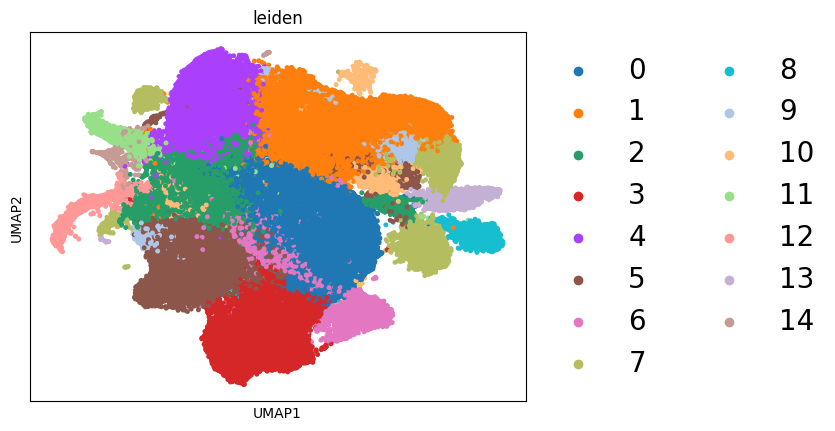

In [77]:
sc.pl.umap(adata,color=['leiden'],size=50,legend_fontsize=20)


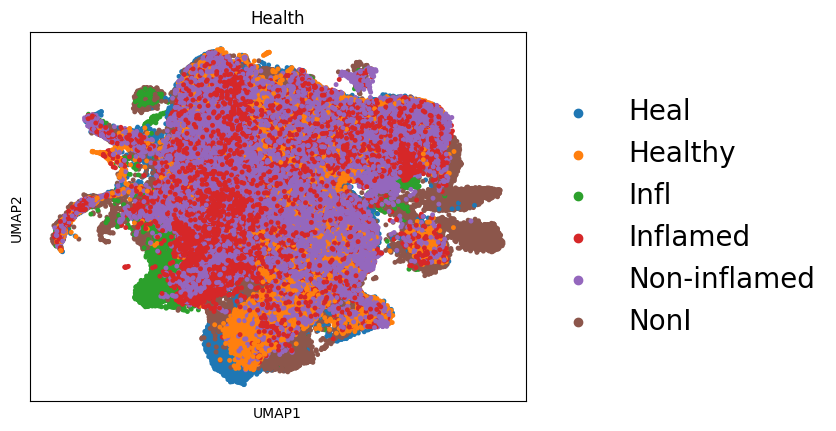

In [78]:
sc.pl.umap(adata,color=['Health'],size=50,legend_fontsize=20)


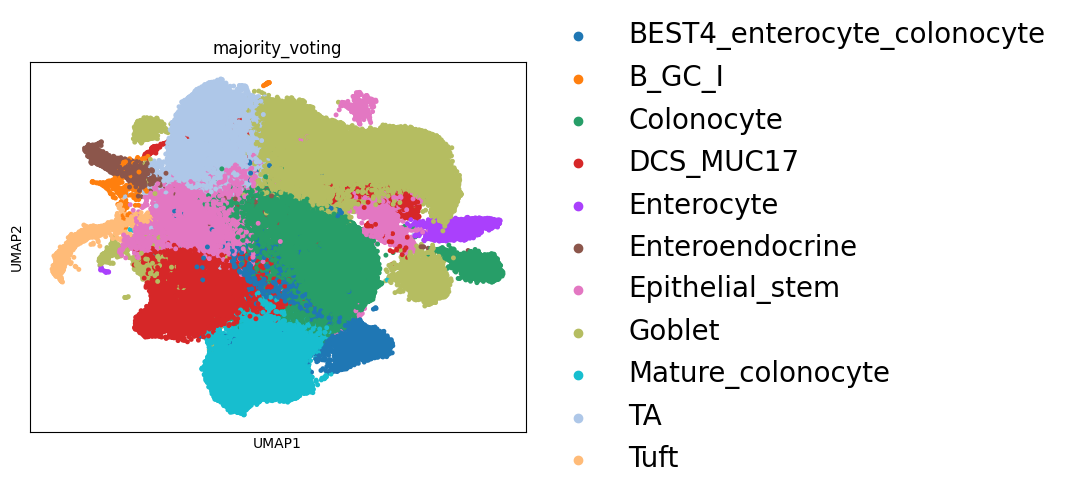

In [79]:
sc.pl.umap(adata,color=['majority_voting'],size=50,legend_fontsize=20)


In [21]:
#adata.obs['cell_label'] = adata.obs['majority_voting']

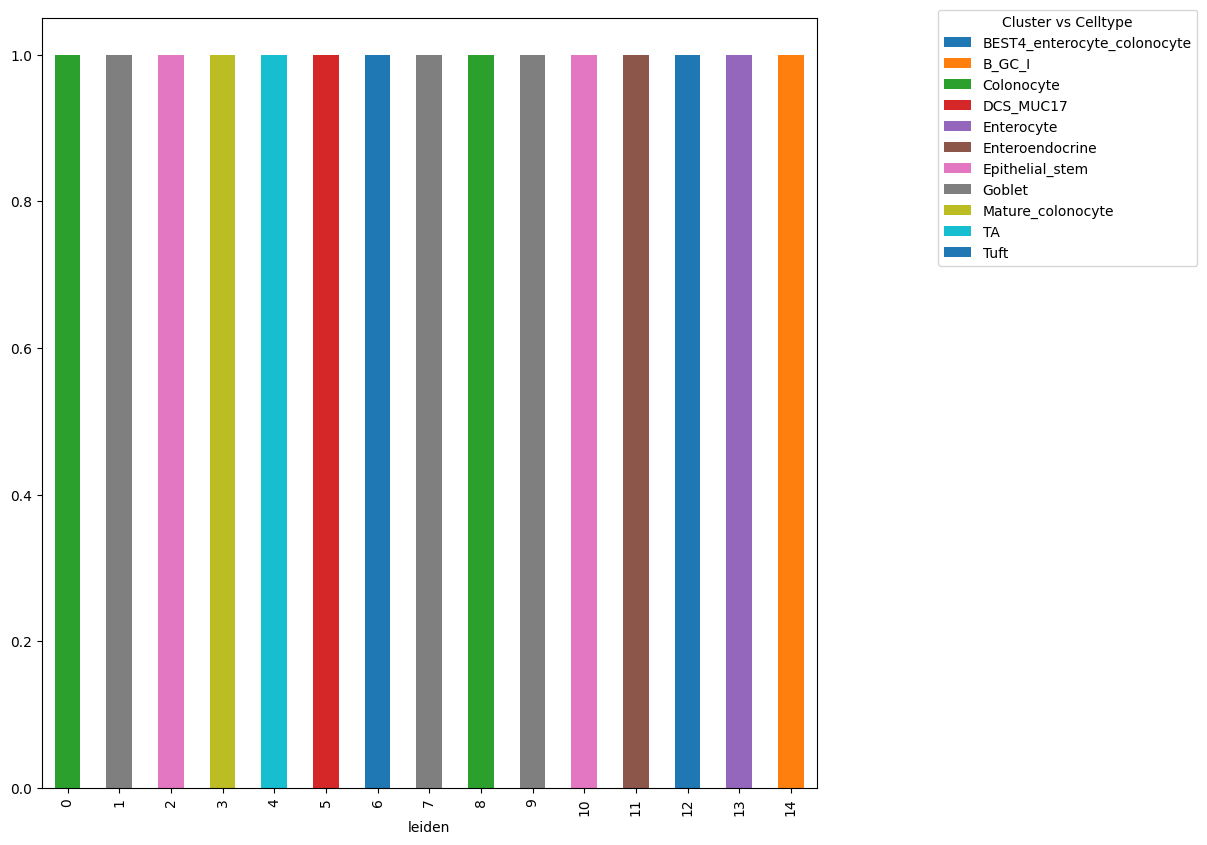

In [80]:
tmp = pd.crosstab(adata.obs['majority_voting'],adata.obs['leiden'], normalize='columns').T.plot(kind='bar', stacked=True, figsize=(10,10))
tmp.legend(title='Cluster vs Celltype', bbox_to_anchor=(1.5, 1.02),loc='upper right')

In [81]:
adata.obs['cell_label'] = adata.obs['leiden']

In [82]:
leiden_label = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14']
cell_label = ['Colonocyte_1','Goblet_1','Stem_1','Mat_Colonocyte','TA','DCS','BEST4+','Goblet_2','Colonocyte_2','Goblet_3','Stem_2','Enteroendocrine','Tuft','Enterocyte','B_GC_I']

In [83]:
adata.obs['cell_label'] = adata.obs['cell_label'].replace(leiden_label,cell_label)

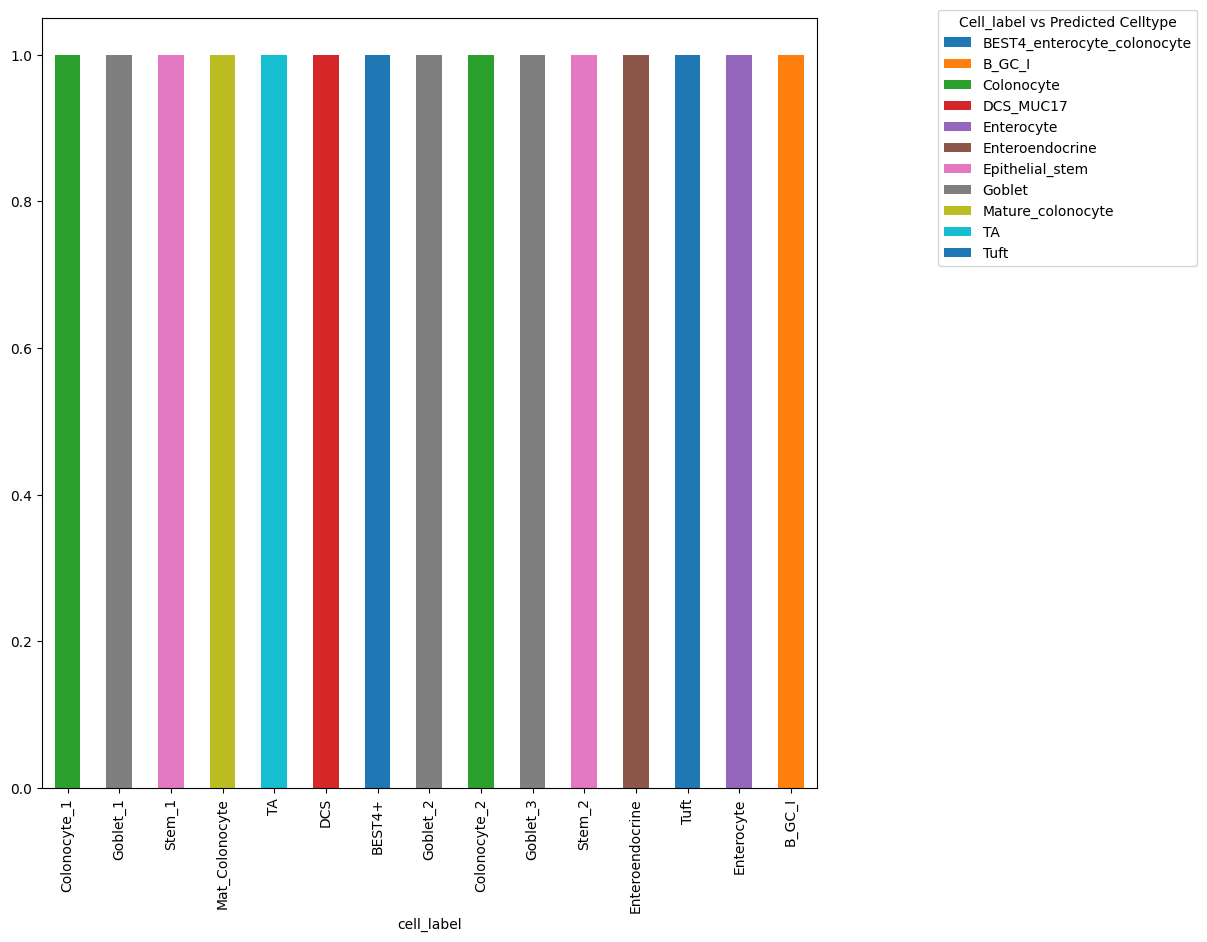

In [84]:
tmp = pd.crosstab(adata.obs['majority_voting'],adata.obs['cell_label'], normalize='columns').T.plot(kind='bar', stacked=True, figsize=(10,10))
tmp.legend(title='Cell_label vs Predicted Celltype', bbox_to_anchor=(1.5, 1.02),loc='upper right')

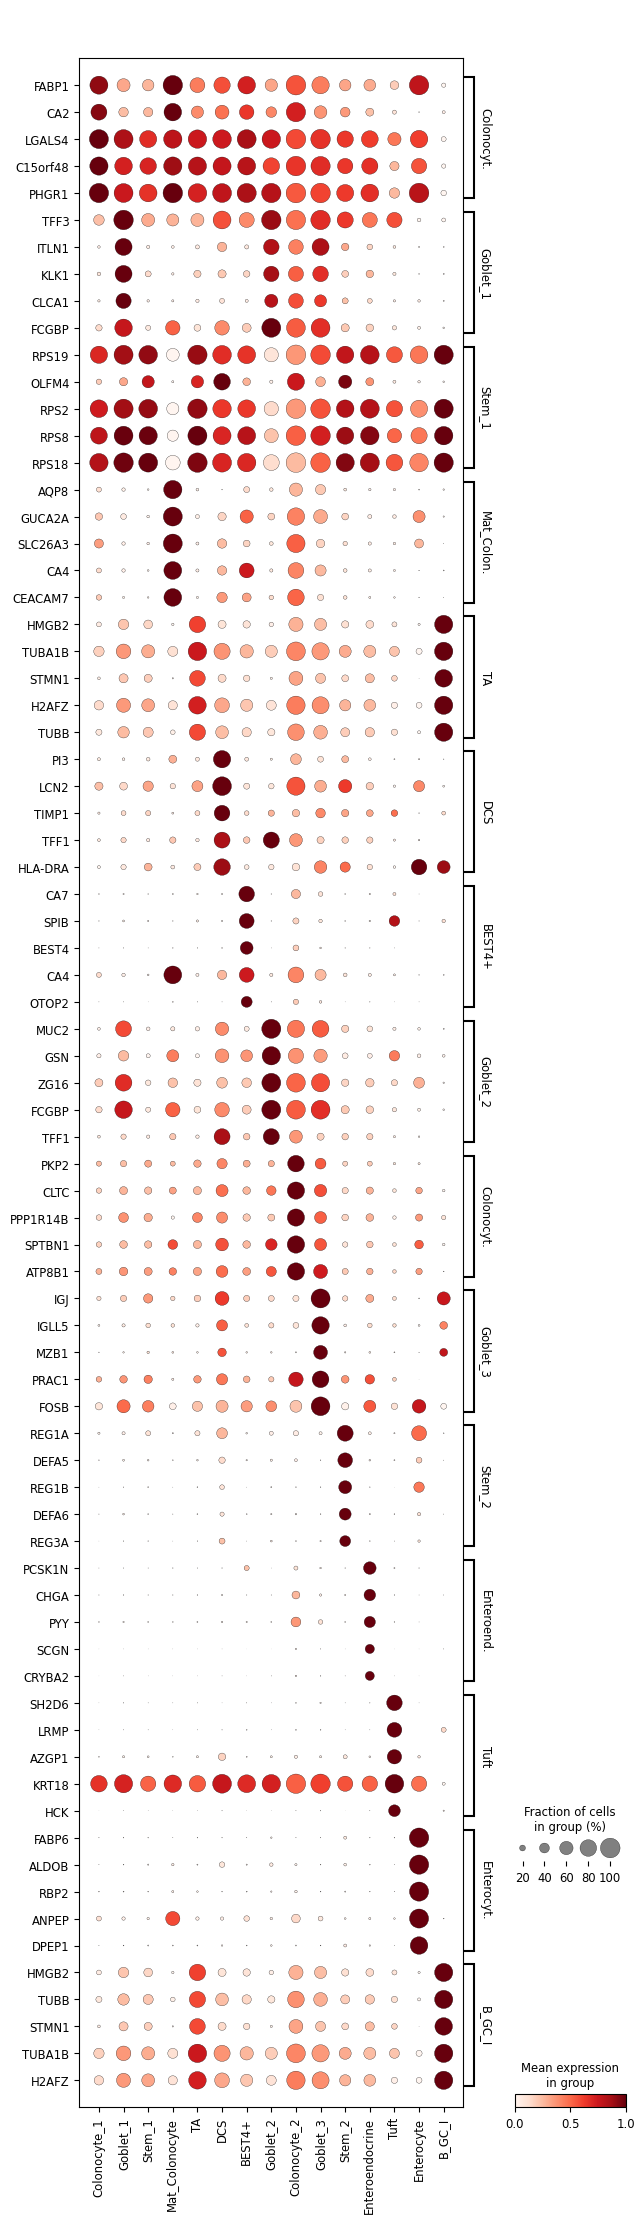

In [85]:
sc.tl.rank_genes_groups(adata, method="wilcoxon", groupby="cell_label")
sc.pl.rank_genes_groups_dotplot(adata, swap_axes=True, dendrogram=False, n_genes=5,standard_scale='var')


In [ ]:
#adata.obs['cell_label'] = adata.obs['cell_label'].replace('old_category,'new_category')

In [86]:
#re-label B_GC_I to TA
adata.obs['cell_label'] = adata.obs['cell_label'].replace('B_GC_I','TA')

In [87]:
#combine goblet cells
adata.obs['cell_label'] = adata.obs['cell_label'].replace('Goblet_2','Goblet_1')
adata.obs['cell_label'] = adata.obs['cell_label'].replace('Goblet_3','Goblet_1')

In [88]:
#combine colonocyte 1 +2
adata.obs['cell_label'] = adata.obs['cell_label'].replace('Colonocyte_2','Colonocyte_1')

In [89]:
#correct Stem_2 to Paneth
adata.obs['cell_label'] = adata.obs['cell_label'].replace('Stem_2','Paneth')

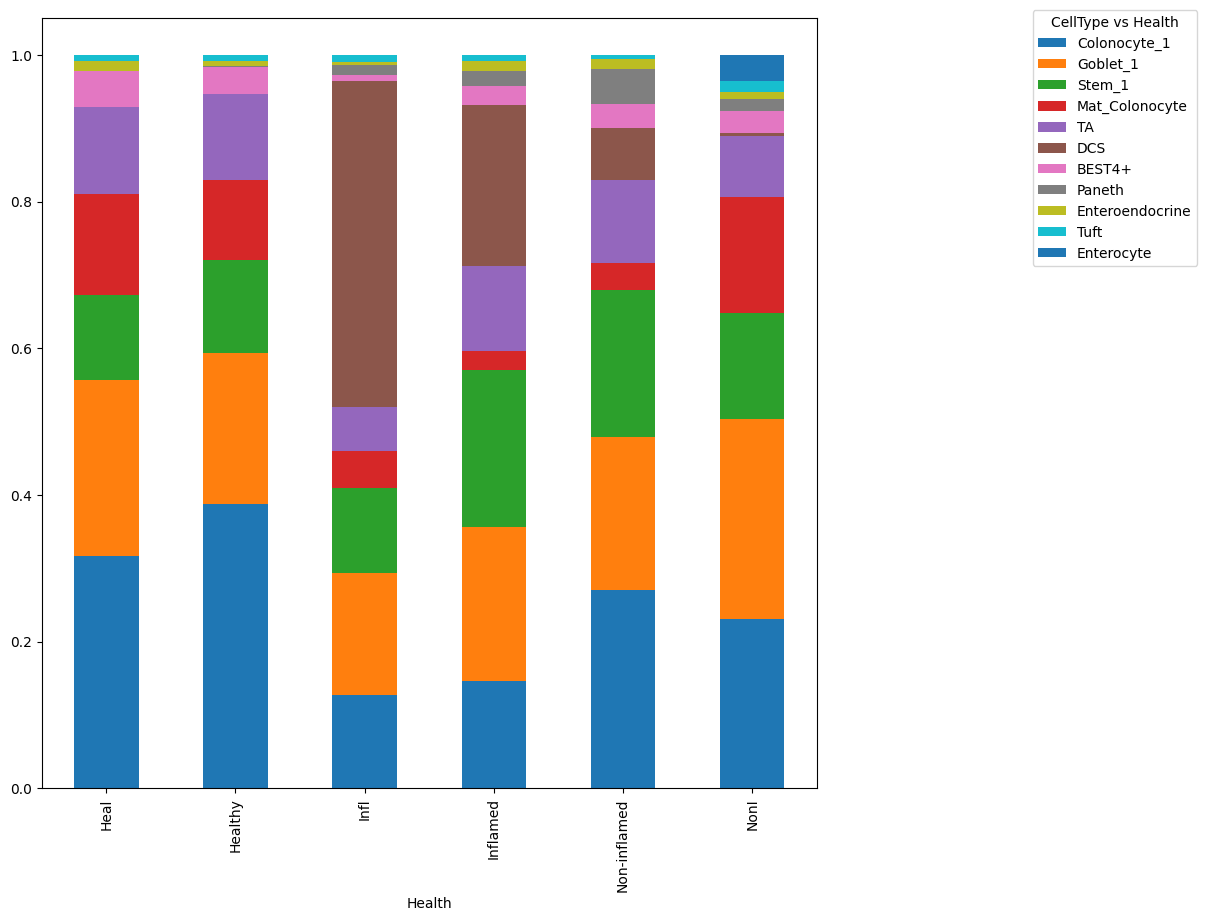

In [90]:
tmp = pd.crosstab(adata.obs['cell_label'],adata.obs['Health'], normalize='columns').T.plot(kind='bar', stacked=True, figsize=(10,10))
tmp.legend(title='CellType vs Health', bbox_to_anchor=(1.5, 1.02),loc='upper right')


In [91]:
adata.write_h5ad(data_path + 'combined.epi.anno.h5ad')